In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
#from ridgeplot import ridgeplot
import joypy

# Simularea de exemple in care asumptiile nu sunt indeplinite

In acest notebook se prezinta exemple in care asumptiile modelului liniar nu sunt indeplinite. Facand acest exercitiu veti intelege mai bine ce probleme implica un model care nu respecta ipotezele.

Structura:

* Simularea relatiei dintre venit si consum in care se respecta asumptiile
* Simularea mai multor scenarii in care una sau mai multe asumptii sunt (intentionat) simulate
* Vizualizarea asumptiilor
* Testarea asumptiilor

Vom genera date x si y care sa respecte asumptiile, iar apoi alte exemple astfel incat un model liniar sa aiba incalcate diferite asumptii.


In [17]:
n_observations = 100000

#normal distributed scenario
# mean_income = 10000
# std_income = 3000
# incomes = np.random.normal(loc=mean_income, scale=std_income,size=n_observations)

#uniform distributed
low_param = 2000
high_param = 25000
incomes = np.random.uniform(low=low_param, high=high_param,size=n_observations)

df = pd.DataFrame({'income':incomes})
df


,income
0,5849.308116
1,10774.494620
2,9888.342272
3,8292.764047
4,3049.072767
...,...
99995,14959.224224
99996,18167.430898
99997,6406.488548
99998,20062.191699


In [18]:
b0 = 1000
b1 = 0.6
error_mean = 0
error_std = 500

def generate_consumption(x: float, beta0: float, beta1: float, error_mean: float, error_std: float) -> float:
    """
    Generate a simulated consumption value (y) based on a linear regression model.
    
    The model follows the equation:
        y = beta0 + beta1 * x + error
    where 'error' is drawn from a normal distribution with specified mean and standard deviation.
    
    Parameters:
        x (float): The independent variable value.
        beta0 (float): The intercept of the linear model.
        beta1 (float): The coefficient for the independent variable.
        error_mean (float): The mean of the normally distributed error term.
        error_std (float): The standard deviation of the normally distributed error term.
    
    Returns:
        float: The generated dependent variable (y) value.
    
    Example:
        >>> generate_consumption(2.0, 1.0, 0.5, 0.0, 1.0)
        2.47
    """
    error = np.random.normal(loc=error_mean, scale=error_std)
    y = beta0 + beta1 * x + error
    return y
df['consumption_v1'] = df['income'].apply(generate_consumption, args=(b0, b1, error_mean, error_std))
df

,income,consumption_v1
0,5849.308116,4067.411018
1,10774.494620,6873.779817
2,9888.342272,7188.431351
3,8292.764047,5966.424581
4,3049.072767,2938.011075
...,...,...
99995,14959.224224,10372.881152
99996,18167.430898,11795.156763
99997,6406.488548,4558.022932
99998,20062.191699,12782.094368


In exemplul de mai jos avem varianta 2 de simulare, in care varianta erorii se schimba in functie de x (venit). In acest fel, varianta va fi diferita a (rezulta heteroscedasticitate).

In [19]:
def generate_consumption_v2(x: float, beta0: float, beta1: float, error_mean: float, error_std: float) -> float:
    """
    Generate a simulated consumption value (y) based on a linear regression model with heteroscedastic errors.

    The model follows the equation:
        y = beta0 + beta1 * x + error
    where 'error' is drawn from a normal distribution with a mean of `error_mean` and a standard deviation that scales with `x`.
    Specifically, the standard deviation of the error term increases as `x` increases, simulating heteroscedasticity.

    Parameters:
        x (float): The independent variable value (e.g., income).
        beta0 (float): The intercept of the linear model.
        beta1 (float): The coefficient for the independent variable.
        error_mean (float): The mean of the normally distributed error term.
        error_std (float): The base standard deviation of the normally distributed error term.

    Returns:
        float: The generated dependent variable (y) value (e.g., consumption).

    Example:
        >>> generate_consumption_v2(1000.0, 50.0, 0.8, 0.0, 10.0)
        850.23  # Example output, actual value will vary due to randomness
    """
    # Generate an updated error standard deviation that scales with x
    error_std_updated = x * 0.0005 * error_std
    
    # Simulate the consumption value (y) using the linear model and heteroscedastic error
    y = beta0 + beta1 * x + np.random.normal(loc=error_mean, scale=error_std_updated)
    
    return y

df['consumption_v2'] = df['income'].apply(generate_consumption_v2, args=(b0, b1, error_mean, error_std))
df

,income,consumption_v1,consumption_v2
0,5849.308116,4067.411018,2955.748900
1,10774.494620,6873.779817,6248.864765
2,9888.342272,7188.431351,5656.086094
3,8292.764047,5966.424581,7429.888166
4,3049.072767,2938.011075,1453.233415
...,...,...,...
99995,14959.224224,10372.881152,3124.762518
99996,18167.430898,11795.156763,15313.504601
99997,6406.488548,4558.022932,5186.754772
99998,20062.191699,12782.094368,2336.287580


In varianta 3 de simulare, media erorilor nu este 0, se schimba pentru diferite intervale ale lui X. In acest fel modelul liniar rezultat in urma acestor date simulate va fi fortat sa fie deplasat.

In [20]:
def generate_consumption_v3(x: float, beta0: float, beta1: float, error_mean: float, error_std: float) -> float:
    """
    Generate a simulated consumption value (y) based on a linear regression model with conditional bias in the error term.

    The model follows the equation:
        y = beta0 + beta1 * x + error
    where 'error' is drawn from a normal distribution with a mean that is conditionally updated based on the value of `x`:
        - If 7000 < x < 9000, the error mean is increased by x * 0.3.
        - If 9000 < x < 11000, the error mean is decreased by x * 0.3.
    Outside these ranges, the error mean remains unchanged.

    Parameters:
        x (float): The independent variable value (e.g., income).
        beta0 (float): The intercept of the linear model.
        beta1 (float): The coefficient for the independent variable.
        error_mean (float): The base mean of the normally distributed error term.
        error_std (float): The standard deviation of the normally distributed error term.

    Returns:
        float: The generated dependent variable (y) value (e.g., consumption).

    Example:
        >>> generate_consumption_v3(8000.0, 50.0, 0.8, 0.0, 10.0)
        6450.23  # Example output, actual value will vary due to randomness
    """
    # Initialize the updated error mean with the base value
    error_mean_updated = error_mean

    # Conditionally update the error mean based on the value of x
    if (x > 7000) and (x < 9000):
        error_mean_updated = error_mean + x * 0.3
    elif (x > 9000) and (x < 11000):
        error_mean_updated = error_mean - x * 0.3

    # Simulate the consumption value (y) using the linear model and updated error mean
    y = beta0 + beta1 * x + np.random.normal(loc=error_mean_updated, scale=error_std)

    return y

df['consumption_v3'] = df['income'].apply(generate_consumption_v3, args=(b0, b1, error_mean, error_std))
df

,income,consumption_v1,consumption_v2,consumption_v3
0,5849.308116,4067.411018,2955.748900,5276.275221
1,10774.494620,6873.779817,6248.864765,3589.550635
2,9888.342272,7188.431351,5656.086094,3442.547391
3,8292.764047,5966.424581,7429.888166,9088.322426
4,3049.072767,2938.011075,1453.233415,3099.943530
...,...,...,...,...
99995,14959.224224,10372.881152,3124.762518,9825.873991
99996,18167.430898,11795.156763,15313.504601,11826.857986
99997,6406.488548,4558.022932,5186.754772,5021.745267
99998,20062.191699,12782.094368,2336.287580,12720.359922


Un alt exemplu de legatura intre x si y prezentat mai jos combina media erorilor diferita de 0 cu varianta diferita. Mai mult, introducem si o deplasare a erorilor pentru x mare. 


In [ ]:
def generate_consumption_v4(x: float, beta0: float, beta1: float, error_mean: float, error_std: float) -> float:
    """
    Generate a simulated consumption value (y) based on a linear regression model with violations of non-biased errors
    and homoscedasticity, and an additional trend in errors for high values of x.

    The model follows the equation:
        y = beta0 + beta1 * x + error
    where 'error' is drawn from a normal distribution with:
        - A randomly updated mean (`error_mean_updated`) between -200 and 200.
        - A randomly updated standard deviation (`error_std_updated`) between 0 and 800.
    Additionally, for x > 17000, the error mean is further increased by x * 0.5, introducing a trend of bias for high values of x.

    Parameters:
        x (float): The independent variable value (e.g., income).
        beta0 (float): The intercept of the linear model.
        beta1 (float): The coefficient for the independent variable.
        error_mean (float): The base mean of the normally distributed error term (unused in this version).
        error_std (float): The base standard deviation of the normally distributed error term (unused in this version).

    Returns:
        float: The generated dependent variable (y) value (e.g., consumption).

    Example:
        >>> generate_consumption_v4(18000.0, 50.0, 0.8, 0.0, 10.0)
        14450.23  # Example output, actual value will vary due to randomness
    """
    # Randomly update the error mean and standard deviation
    error_mean_updated = np.random.uniform(-200, 200)
    error_std_updated = np.random.uniform(0, 800)

    # Introduce a trend of bias for high values of x
    if x > 17000:
        error_mean_updated = abs(error_mean_updated) + x * 0.5

    # Simulate the consumption value (y) using the linear model and updated error parameters
    y = beta0 + beta1 * x + np.random.normal(loc=error_mean_updated, scale=error_std_updated)

    return y

df['consumption_v4'] = df['income'].apply(generate_consumption_v4, args=(b0, b1, error_mean, error_std))
df.head()

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4
0,5849.308116,4067.411018,2955.748900,5276.275221,4776.352182
1,10774.494620,6873.779817,6248.864765,3589.550635,7385.233133
2,9888.342272,7188.431351,5656.086094,3442.547391,5615.377177
3,8292.764047,5966.424581,7429.888166,9088.322426,5889.443234
4,3049.072767,2938.011075,1453.233415,3099.943530,2738.446595
...,...,...,...,...,...
99995,14959.224224,10372.881152,3124.762518,9825.873991,10122.992754
99996,18167.430898,11795.156763,15313.504601,11826.857986,21274.627787
99997,6406.488548,4558.022932,5186.754772,5021.745267,4894.433324
99998,20062.191699,12782.094368,2336.287580,12720.359922,22340.490287


In [23]:
# Define scenarios and the corresponding y column names
scenarios = [1, 2, 3, 4]
scenario_y_names = [f'consumption_v{i}' for i in scenarios]

# Estimate the relationship between the simulated scenarios using linear regression
df_sample = df.sample(1000)  # Use a sample of 1000 rows
print("Results\n")

# Store models in a dictionary for later use
models = {}

for scenario in scenarios:
    formula = f"consumption_v{scenario} ~ income"
    model = smf.ols(formula=formula, data=df_sample).fit()
    models[f'model_v{scenario}'] = model  # Store the model in the dictionary
    
    print(f"Version {scenario}:\n")
    print(model.summary())
    print("\n\n")


Results

Version 1:

                            OLS Regression Results                            
Dep. Variable:         consumption_v1   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 6.958e+04
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:03:21   Log-Likelihood:                -7586.0
No. Observations:                1000   AIC:                         1.518e+04
Df Residuals:                     998   BIC:                         1.519e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1006.7509     34.69

In [ ]:
# Get predictions and errors for each scenario
for scenario in scenarios:
    model = models[f'model_v{scenario}']  # Access the model from the dictionary
    df[f"pred_v{scenario}"] = model.predict(df['income']) 
    df[f"error_v{scenario}"] = df[f'consumption_v{scenario}'] - df[f"pred_v{scenario}"]

df.head()

         income  consumption_v1  consumption_v2  consumption_v3  \
0   5849.308116     4067.411018     2955.748900     5276.275221   
1  10774.494620     6873.779817     6248.864765     3589.550635   
2   9888.342272     7188.431351     5656.086094     3442.547391   
3   8292.764047     5966.424581     7429.888166     9088.322426   
4   3049.072767     2938.011075     1453.233415     3099.943530   

   consumption_v4      pred_v1    error_v1      pred_v2     error_v2  \
0     4776.352182  4510.922923 -443.511905  4418.759303 -1463.010402   
1     7385.233133  7461.477117 -587.697301  7423.760597 -1174.895833   
2     5615.377177  6930.605743  257.825608  6883.092960 -1227.006865   
3     5889.443234  5974.735337   -8.310756  5909.583707  1520.304460   
4     2738.446595  2833.373017  104.638058  2710.253271 -1257.019856   

       pred_v3     error_v3      pred_v4     error_v4  
0  4508.157847   768.117374  3061.393431  1714.958751  
1  7443.870156 -3854.319522  9258.538153 -1873.30502

# Vizualizarea asumptiilor

### 1. Liniaritate

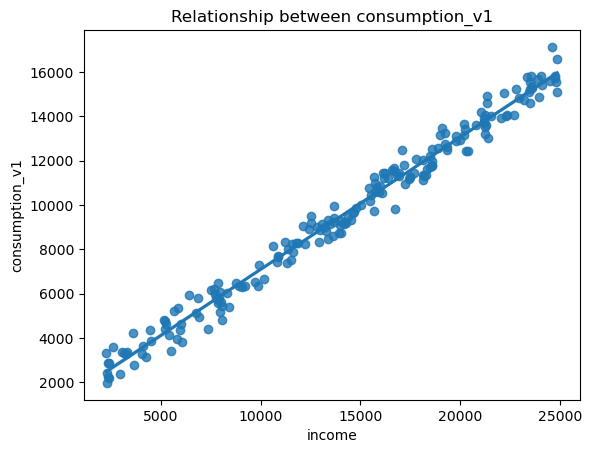

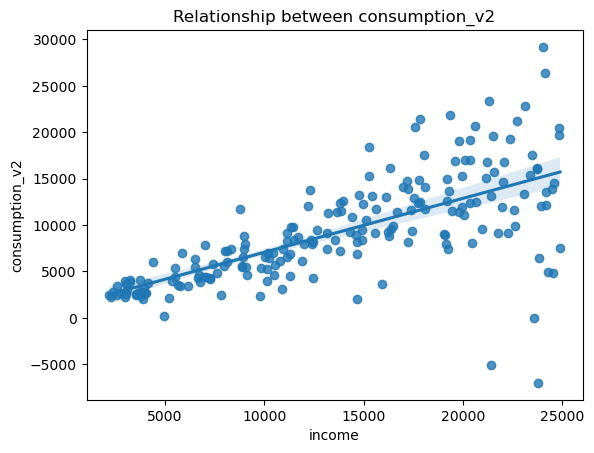

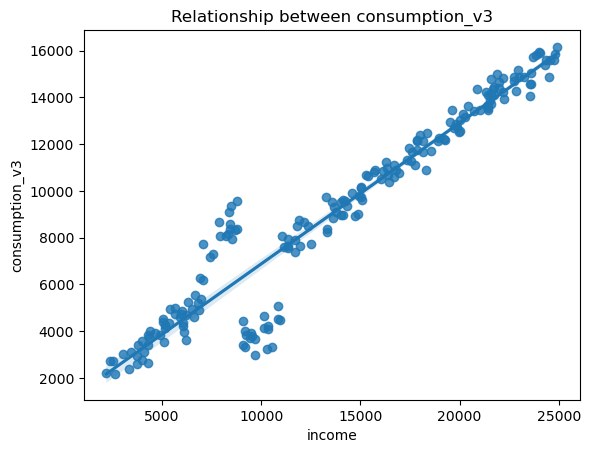

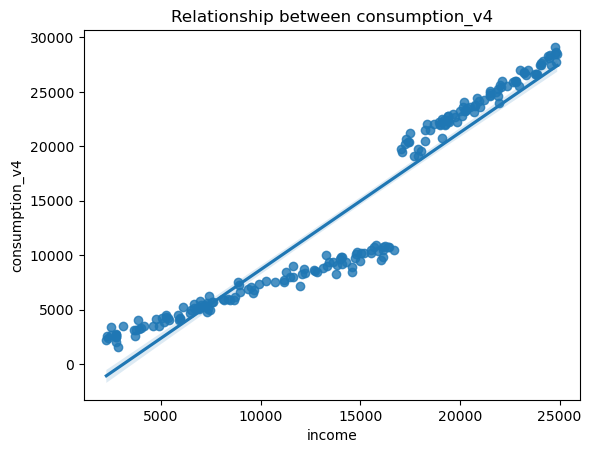

In [25]:

for scenario in scenario_y_names:
    relationship_plot = sns.regplot(data=df.sample(200), x='income',y=scenario)
    relationship_plot.set_title(f"Relationship between {scenario}")
    plt.show()


* In primul grafic se vede clar liniaritatea, _norul_ de puncte e omogen, are cam aceeasi _latime_ (varianta), iar linia (legatura estimata) este chiar prin mijlocul _norului_ (rezulta ca modelul nu e deplasat). 
* In al doilea grafic varianta erorilor creste pe masura ce x creste => Heteroscedasticitate
* In al treilea se vad doua pattern-uri pentru X unde modelul e clar deplasat (media erorilor pentru orice x nu e zero)
* In graficul 4 se observa un ca folosind un model liniar clasic nu este suficient pentru a capta pattern-ul, astfel rezulta un model deplasat. 

### 2. Eroarea conditionata este 0 

Pentru fiecare x (sau interval de x) media erorilor trebuie sa fie 0. 



### 3. Homoscedasticitatea

Pentru fiecare x (sau interval de x)



In [26]:
#Define the bins and labels
bins = range(2000, 30001, 500)
labels = [f"{i}_{i+500}" for i in range(2000, 30000, 500)]

# Add a new column with the interval labels
df['interval_income'] = pd.cut(df['income'], bins=bins, labels=labels, right=False)

df

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,error_v1,pred_v2,error_v2,pred_v3,error_v3,pred_v4,error_v4,interval_income
0,5849.308116,4067.411018,2955.748900,5276.275221,4776.352182,4510.922923,-443.511905,4418.759303,-1463.010402,4508.157847,768.117374,3061.393431,1714.958751,5500_6000
1,10774.494620,6873.779817,6248.864765,3589.550635,7385.233133,7461.477117,-587.697301,7423.760597,-1174.895833,7443.870156,-3854.319522,9258.538153,-1873.305020,10500_11000
2,9888.342272,7188.431351,5656.086094,3442.547391,5615.377177,6930.605743,257.825608,6883.092960,-1227.006865,6915.669173,-3473.121782,8143.531779,-2528.154602,9500_10000
3,8292.764047,5966.424581,7429.888166,9088.322426,5889.443234,5974.735337,-8.310756,5909.583707,1520.304460,5964.606988,3123.715438,6135.886146,-246.442911,8000_8500
4,3049.072767,2938.011075,1453.233415,3099.943530,2738.446595,2833.373017,104.638058,2710.253271,-1257.019856,2839.046357,260.897173,-462.019073,3200.465668,3000_3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,14959.224224,10372.881152,3124.762518,9825.873991,10122.992754,9968.442382,404.438771,9976.987336,-6852.224819,9938.224878,-112.350887,14523.998649,-4401.005895,14500_15000
99996,18167.430898,11795.156763,15313.504601,11826.857986,21274.627787,11890.397550,-95.240787,11934.408685,3379.095916,11850.512223,-23.654237,18560.743459,2713.884329,18000_18500
99997,6406.488548,4558.022932,5186.754772,5021.745267,4894.433324,4844.715574,-286.692642,4758.711489,428.043283,4840.271454,181.473813,3762.468969,1131.964355,6000_6500
99998,20062.191699,12782.094368,2336.287580,12720.359922,22340.490287,13025.500642,-243.406275,13090.458036,-10754.170456,12979.905516,-259.545594,20944.837317,1395.652969,20000_20500


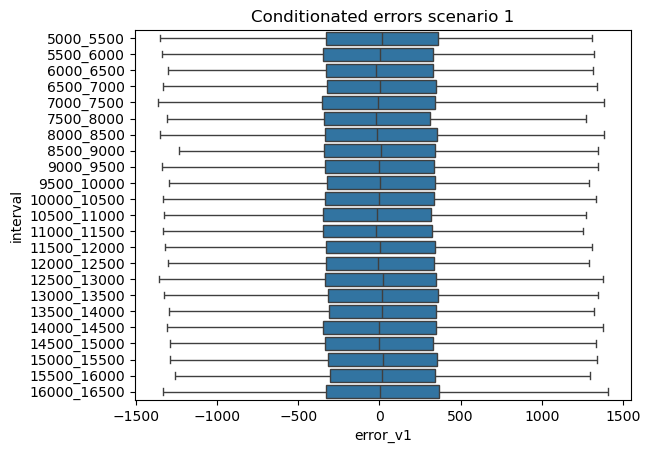

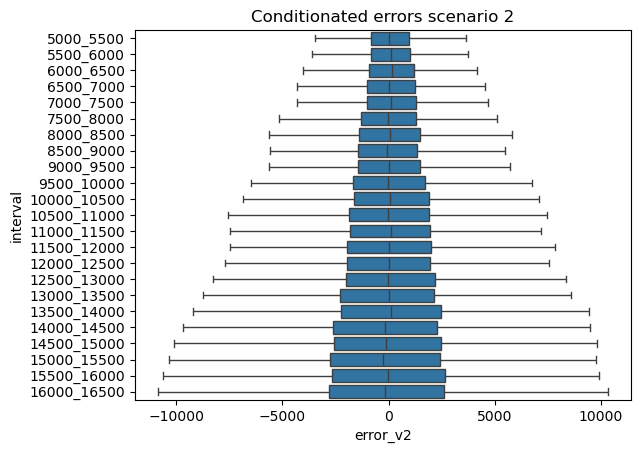

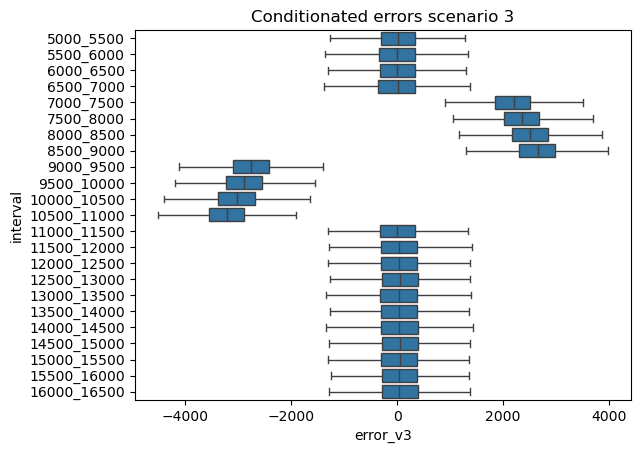

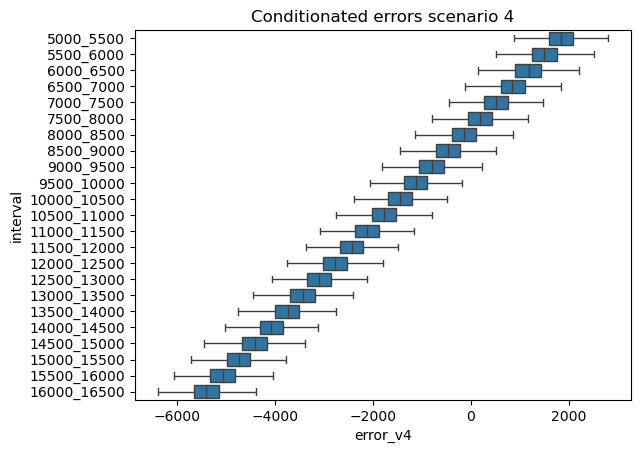

In [27]:
for scenario in scenarios:
    df_sample2 = df[df['income'].between(5000,16500)].copy() 
    df_sample2['interval'] = df_sample2['interval_income'].astype('str')
    df_sample2.sort_values(by='income',inplace=True)
    erori_conditionat_boxplot = sns.boxplot(data=df_sample2, y='interval',x=f"error_v{scenario}", showfliers=False)
    erori_conditionat_boxplot.set_title(f"Conditionated errors scenario {scenario}")
    plt.show()




__Deplasare__

* Grafic 1: Arata bine, pare a fi 0
* Grafic 2: Pare a fi 0
* Grafic 3: Sunt intervale X unde e deplasat
* Grafic 4: Sunt intervale X unde e deplasat


__Heterocedasticitate__

* Grafic 1: Arata bine, pare a fi varianta constanta
* Grafic 2: Desi media e 0, varianta difera
* Grafic 3: Media nu 0, dar varianta pare sa fie la fel
* Grafic 4: Media nu 0, dar varianta pare sa fie la fel

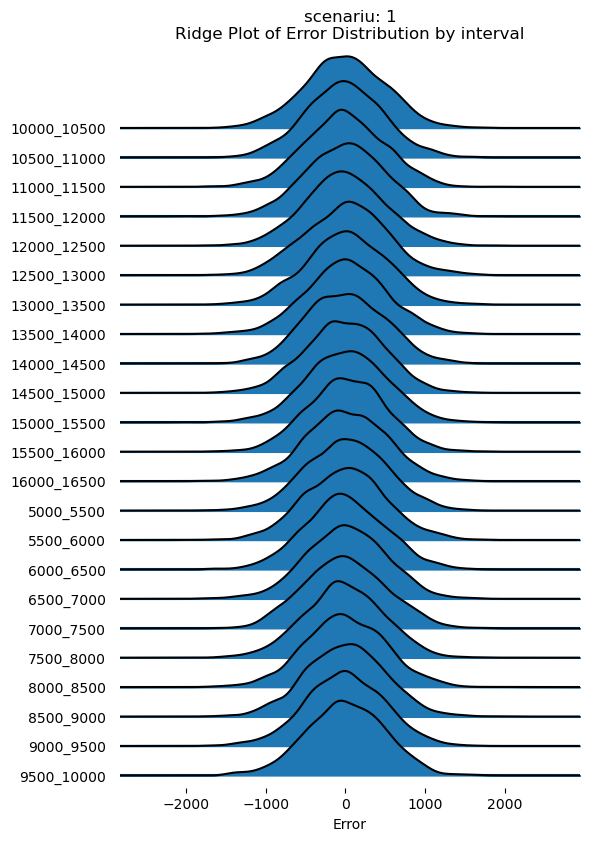

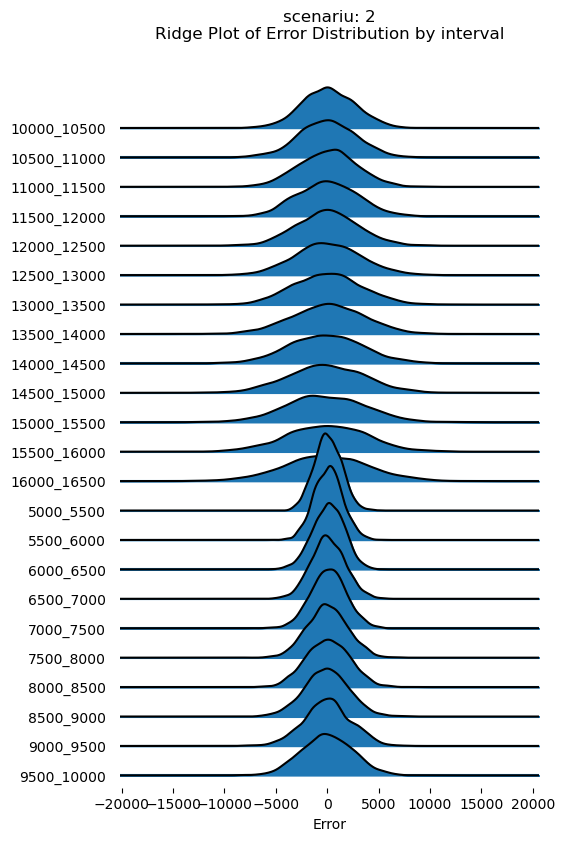

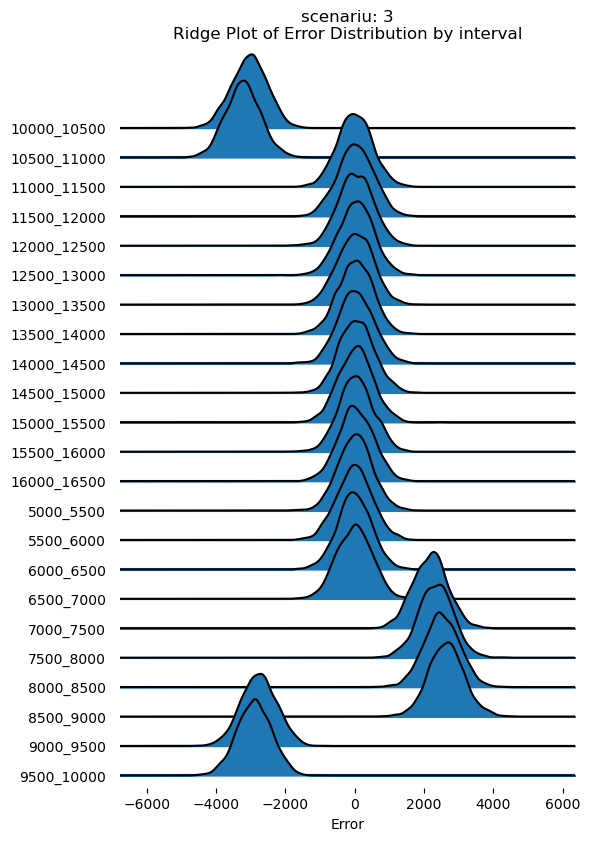

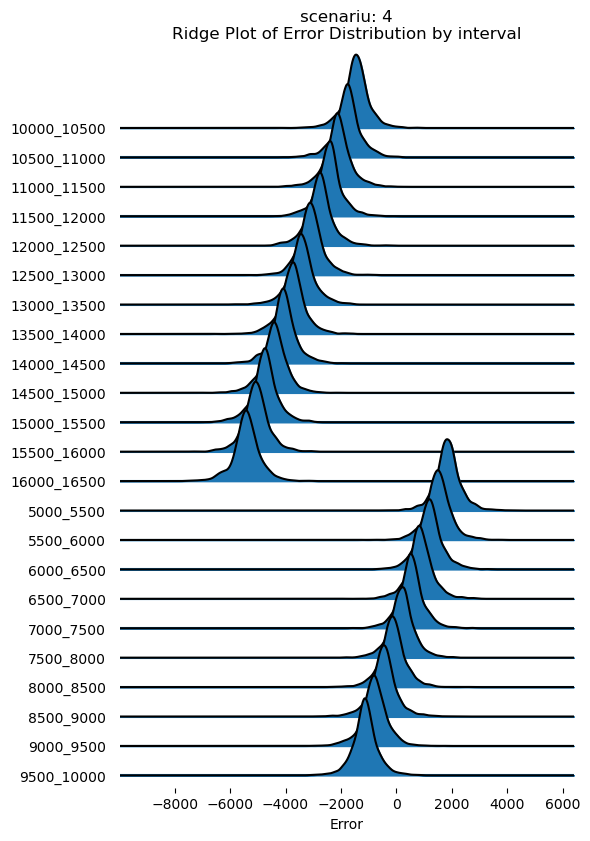

In [28]:
for scenario in scenarios:

    #Create a ridge plot using joypy
    fig, axes = joypy.joyplot(df_sample2, by="interval", column=f"error_v{scenario}", figsize=(6, 8))

    # Customize the plot if needed
    plt.title(f"scenariu: {scenario}\nRidge Plot of Error Distribution by interval")
    plt.xlabel("Error")
    plt.ylabel("Label")
    plt.show()

### 4. Variabile independente necorelate cu erorile

Nu ar trebui sa fie un pattern intre erorile respective. Stiind oricare eroare pentru un anumit x nu ar trebui sa iti ofere vreun indiciu in a sti care e eroarea pentru alt x. 

Grafic 1: Nu este niciun pattern
Grafic 2: 

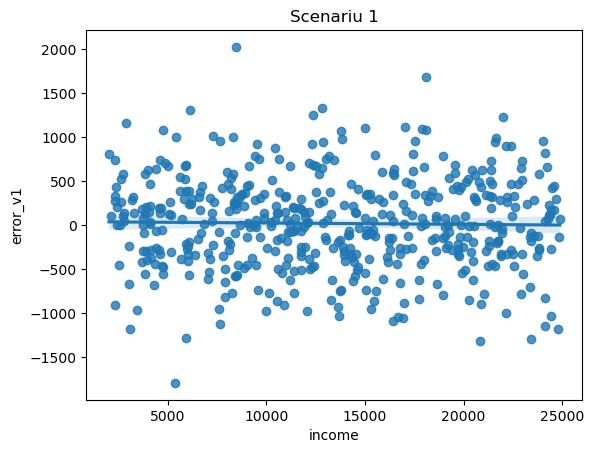

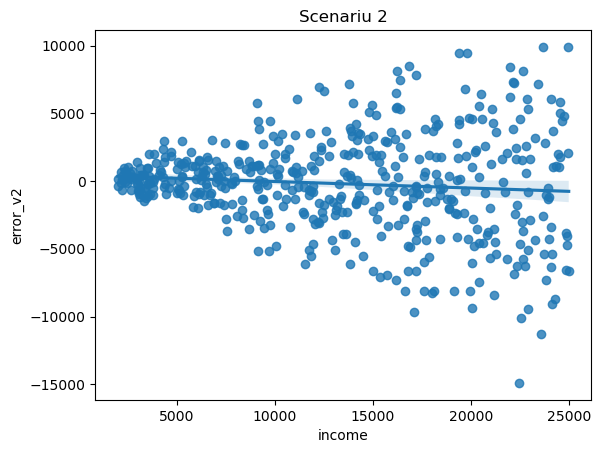

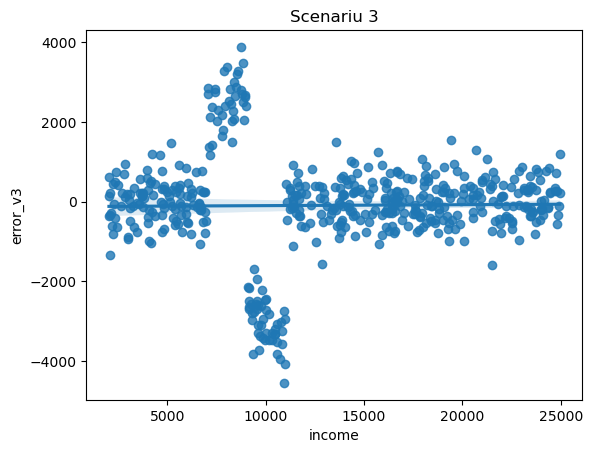

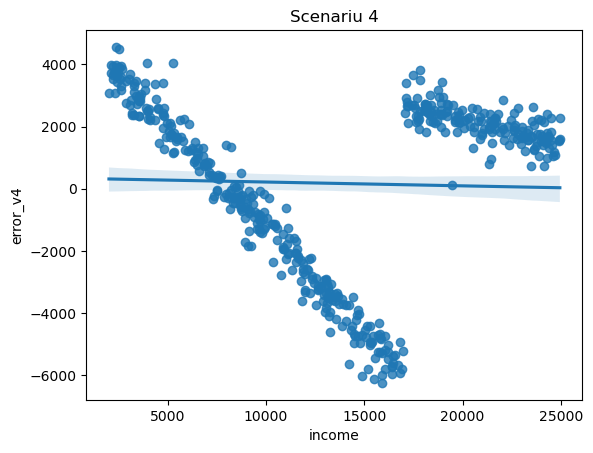

In [ ]:
for scenario in scenarios:
    scatter_plot_errors_x = relationship_plot = sns.regplot(data=df.sample(500), x='income',y=f'error_v{scenario}')
    scatter_plot_errors_x.set_title(f'Scenario {scenario}')
    plt.show()